# LAB 2 - DECOMPOSITIONS AND TESTS

In this first lab, you will be given two tasks:

1. Explore the evolution of the number of employed people in Australia throughout the years. In this case I give you the code to create the required visualizations. Read the descriptions and try to understand what the code does before running it.

2. Explore the evolution of the Chinese GDP. In this case you will need to adapt the code from part 1 to this new time series.

## PART 1 - AUSTRALIAN EMPLOYEES DATA

The file `AustraliaEmployedTotalPersons.xlsx` stores the time series of Australian monthly employed total persons from February 1978 to November 2018 (in thousands). The following code loads the data and creates the time series plot. Comment on its appearance.

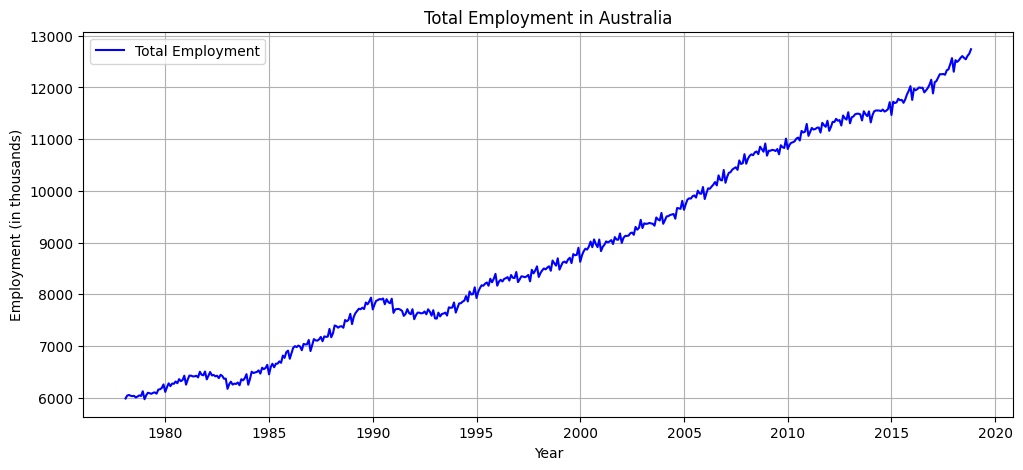

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


# Load dataset
file_path = "CSV_FILES/AustraliaEmployedTotalPersons.xlsx"
df = pd.read_excel(file_path)

# Convert 'yearandmonth' to datetime and set as index
df["yearandmonth"] = pd.to_datetime(df["yearandmonth"])
df.set_index("yearandmonth", inplace=True)
df = df.asfreq("MS")

#  Plot Full Time Series ---
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["EmployedP"], color="blue", label="Total Employment")
plt.title("Total Employment in Australia")
plt.xlabel("Year")
plt.ylabel("Employment (in thousands)")
plt.legend()
plt.grid()
plt.show()

As we can see the time series is quite long and we cannot clearly see its behaviour fully. To help us, the code below only plots the last three years of the time series. What do you observe?

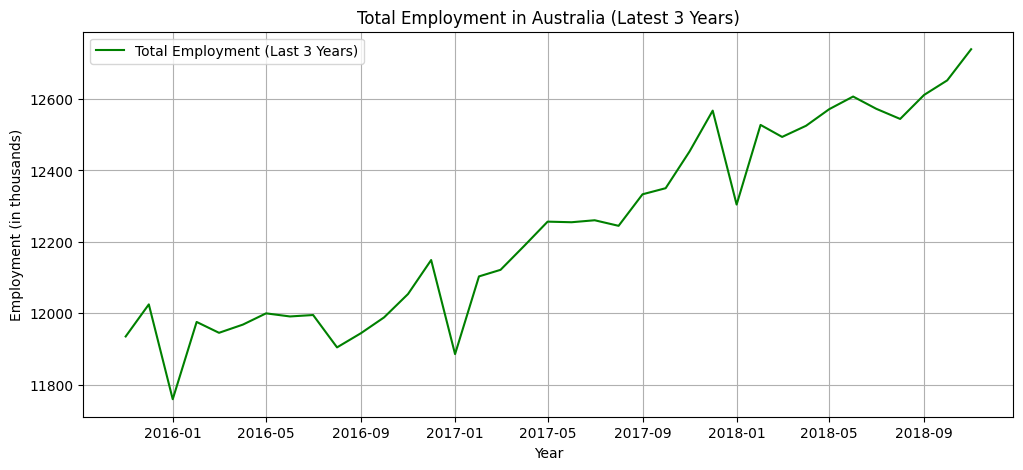

In [6]:
# ---  Plot Time Series for the Latest 3 Years ---
df_last3years = df[df.index >= df.index[-1] - pd.DateOffset(years=3)]

plt.figure(figsize=(12, 5))
plt.plot(df_last3years.index, df_last3years["EmployedP"], color="green", label="Total Employment (Last 3 Years)")
plt.title("Total Employment in Australia (Latest 3 Years)")
plt.xlabel("Year")
plt.ylabel("Employment (in thousands)")
plt.legend()
plt.grid()
plt.show()


The following code creates the decompositions of the time series into their trend, seasonal and residual components under the additive and multiplicative model. Notice we set `period=12` since we have monthly data. Interpret the results. Does the data have seasonal and trend components?

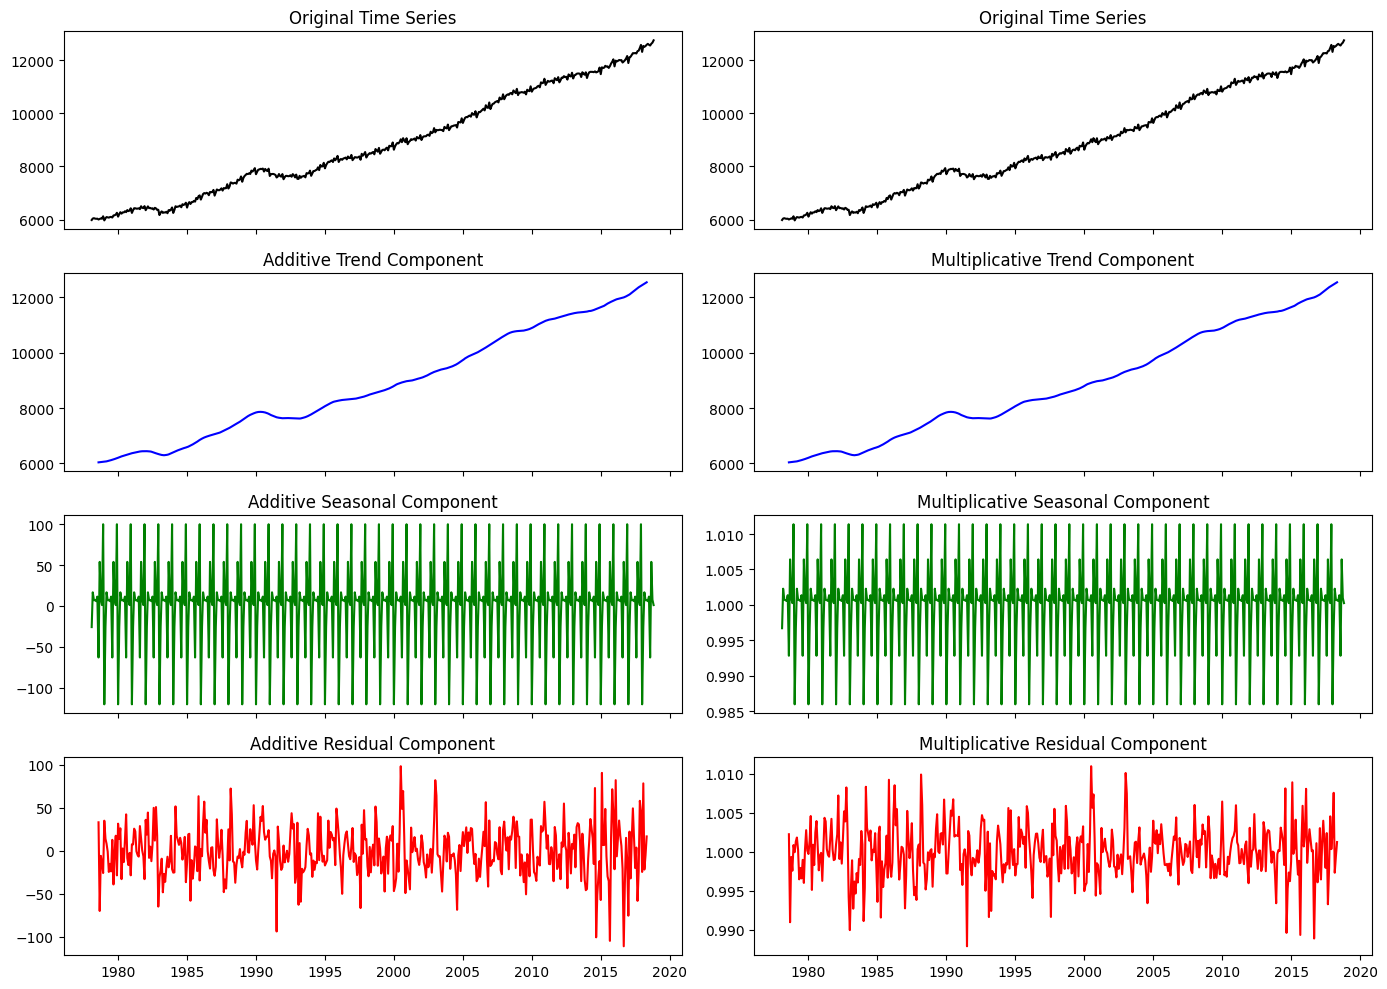

In [7]:

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(df["EmployedP"], model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(df["EmployedP"], model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(df.index, df["EmployedP"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(df.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(df.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(df.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(df.index, df["EmployedP"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(df.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(df.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(df.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()


We next ask ourselves if the residuals of the additive decomposition are stationary. If not, it means that there are additional patterns in the data that the decomposition did not pick up. What does the p-value tell us?

In [8]:
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Statistic: -7.3121
p-value: 0.0000


We also compute the ACF and PACF to check if the residuals are white noise (the ACF would be sufficient, this is to show you how to compute the PACF). What do we observe?

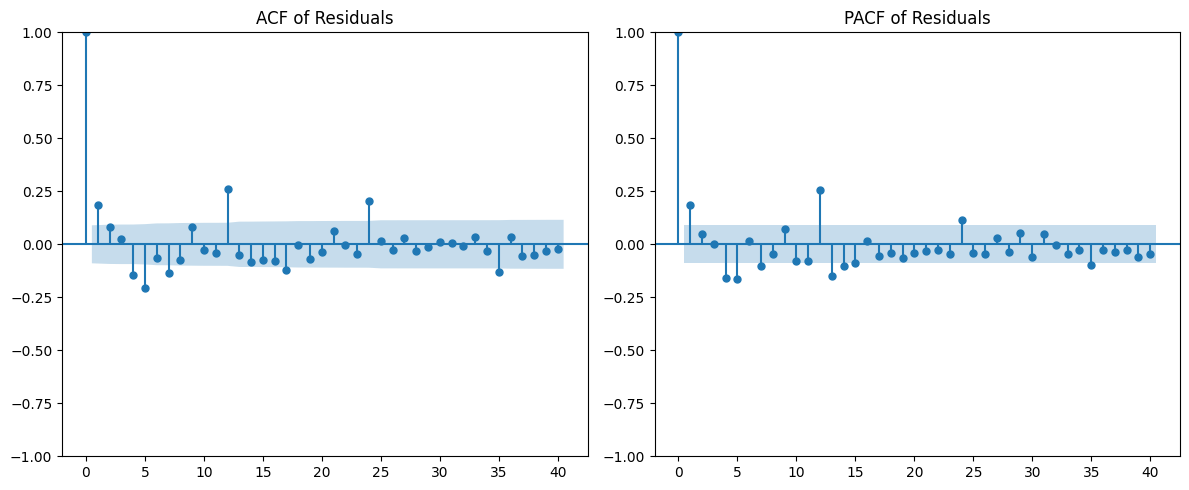

In [9]:
# ---  ACF and PACF Plots of Residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=40, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()


Last, we use the Ljung-Box test, checking if the first 20 autocorrelations are all zero. What does the p-value tell us?

In [22]:
# --- Perform Ljung-Box Test ---
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")
print("Tests if data is whitenoise (if it is then no correllation) low p = not whitenoise")

Ljung-Box p-value: 0.0000
Tests if data is whitenoise (if it is then no correllation) low p = not whitenoise


Finally, we use exponential smoothing to our time series. We did not discuss this in class in details, but we can also decompose a time series with this method. This can be done using the `hw_model` function and setting `trend=add` and `seasonal=add`. Furthermore, we can use this method to forecast the last 12 months of the time series. We fit the decomposition over the whole time series, excluding the last 12 months. We then use the forecast method for the model. As an additional visualization, I also add the confidence intervals of these forecasts. Because of the clear patterns in the data, we are able to actually forecast what happens fairly well!!

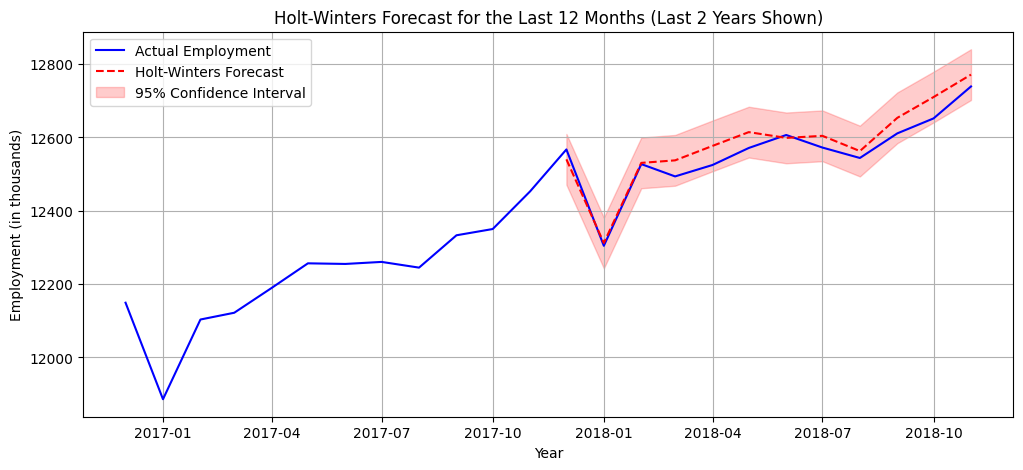

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split the dataset: exclude the last 12 months for training
train_data = df.iloc[:-12]  # Use all but the last 12 months for training
test_data = df.iloc[-12:]   # Last 12 months for testing

# Fit Holt-Winters Exponential Smoothing model (seasonal period = 12 for monthly data)
hw_model = ExponentialSmoothing(
    train_data["EmployedP"],
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit()

# Forecast the next 12 months all at once without refitting
forecast_values = hw_model.forecast(steps=12)

# Estimate confidence intervals using residual standard deviation
residuals = train_data["EmployedP"] - hw_model.fittedvalues
std_dev = np.std(residuals)
confidence_interval = 1.96 * std_dev  # 95% Confidence Interval

# Convert forecasted values to a Pandas Series with the correct index
forecast_series = pd.Series(forecast_values.values, index=test_data.index)

# Select the last two years of actual data for plotting
df_last2years = df.iloc[-24:]  # Show the last 24 months of data

# Plot actual vs forecasted values (only last two years)
plt.figure(figsize=(12, 5))
plt.plot(df_last2years.index, df_last2years["EmployedP"], color="blue", label="Actual Employment")
plt.plot(forecast_series.index, forecast_series, color="red", linestyle="dashed", label="Holt-Winters Forecast")

# Plot confidence intervals
plt.fill_between(
    forecast_series.index,
    forecast_series - confidence_interval,
    forecast_series + confidence_interval,
    color="red", alpha=0.2, label="95% Confidence Interval"
)

plt.title("Holt-Winters Forecast for the Last 12 Months (Last 2 Years Shown)")
plt.xlabel("Year")
plt.ylabel("Employment (in thousands)")
plt.legend()
plt.grid()
plt.show()


## PART 2 - QUARTERLY CHINESE GDP

The file `gdpchina.xlsx` stores the quarterly Chinese GDP from 1996 to 2017 (we worked with it last class). Make sure to upload it to the session for you to use it. The following code loads the data.

In [13]:
# Step 5: Reload the cleaned dataset
gdpchina = pd.read_excel("CSV_FILES/gdpchina.xlsx", index_col="Date", parse_dates=True)

In [16]:
gdpchina.head()

,GDP,CMA
Date,,
1996-03-31,14572.6,NaN
1996-06-30,17286.2,NaN
1996-09-30,18457.9,17638.98
1996-12-31,21255.6,18584.14
1997-03-31,16622.6,19194.62


The following code creates the time series plot together with the centered moving average.

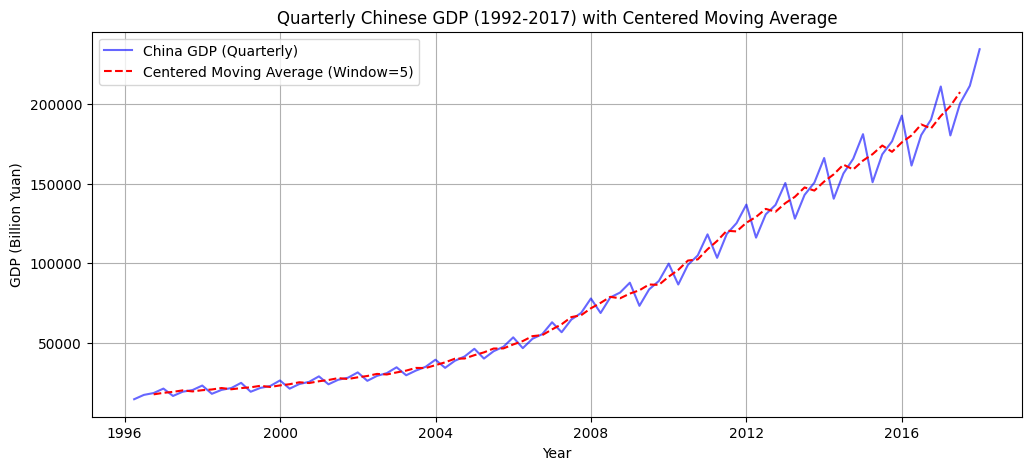

In [14]:
# Define window size for centered moving average (-2 to +2, total window size = 5)
window_size = 5

# Compute Centered Moving Average (CMA)
gdpchina["CMA"] = gdpchina["GDP"].rolling(window=window_size, center=True).mean()

# Plot GDP with Centered Moving Average
plt.figure(figsize=(12, 5))
plt.plot(gdpchina.index, gdpchina["GDP"], label="China GDP (Quarterly)", color="blue", alpha=0.6)
plt.plot(gdpchina.index, gdpchina["CMA"], label=f"Centered Moving Average (Window={window_size})", color="red", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("GDP (Billion Yuan)")
plt.title("Quarterly Chinese GDP (1992-2017) with Centered Moving Average")
plt.legend()
plt.grid()
plt.show()


Apply the additive and multiplicative decompositions to the data. Make sure to use the appopriate period. Which one looks better?

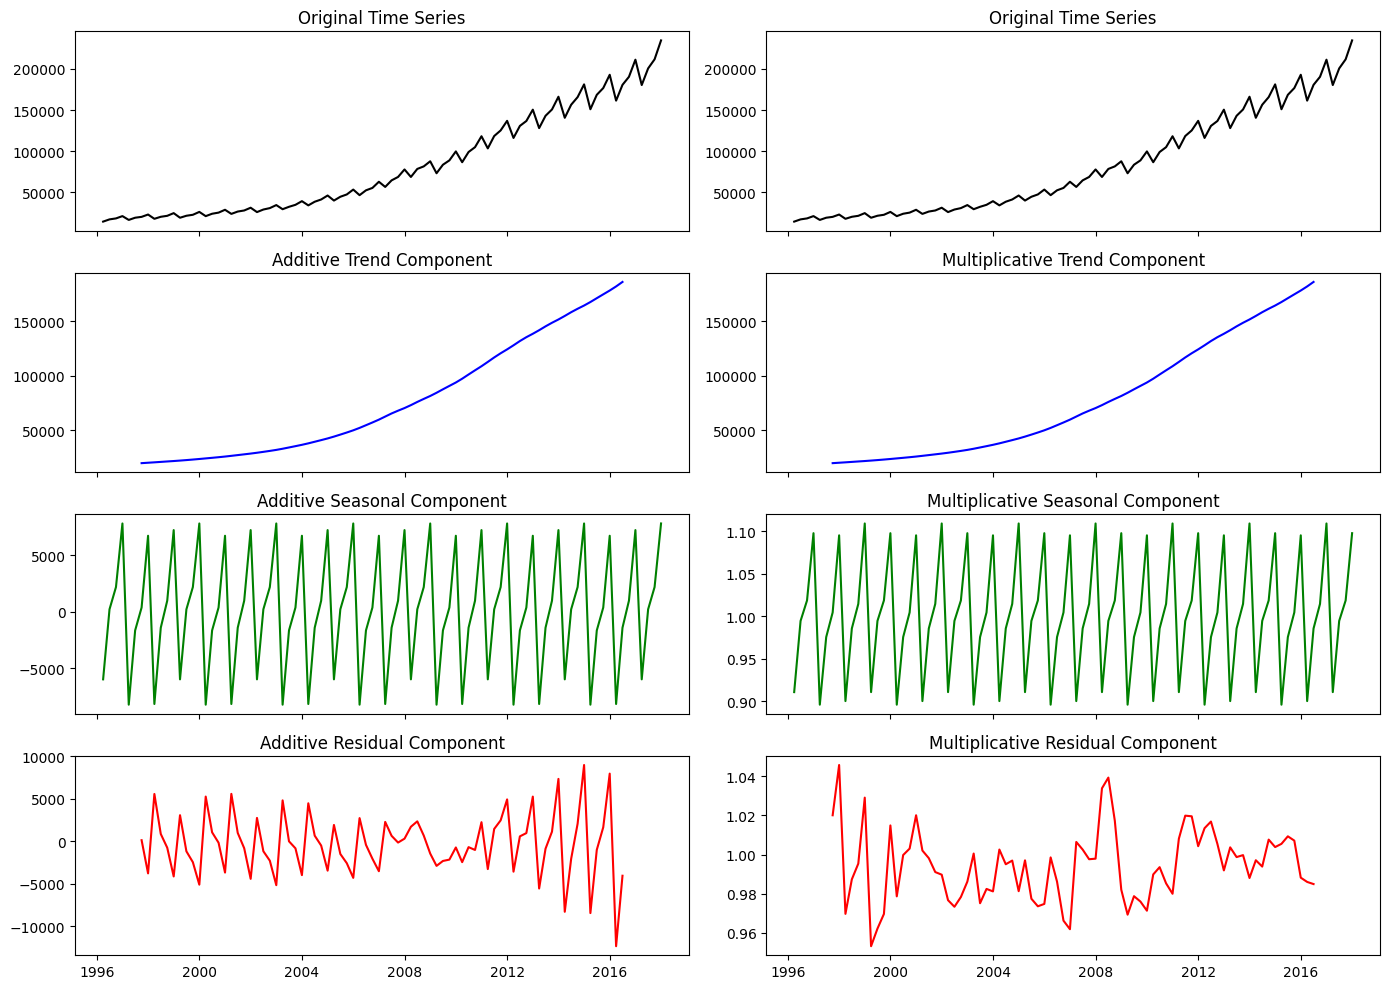

In [17]:
## APPLY THE TWO DECOMPOSITIONS
# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(gdpchina["GDP"], model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(gdpchina["GDP"], model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(gdpchina.index, gdpchina["GDP"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(gdpchina.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(gdpchina.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(gdpchina.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(gdpchina.index, gdpchina["GDP"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(gdpchina.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(gdpchina.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(gdpchina.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()

Create the ACF plot of the residuals of the best decomposition. Also apply the test of stationarity. What do these results tell us?

In [18]:
## COMPUTE THE RESIDUALS
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

## PLOT THE ACF

## COMPUTE THE AD TEST


ADF Statistic: -4.4557
p-value: 0.0002


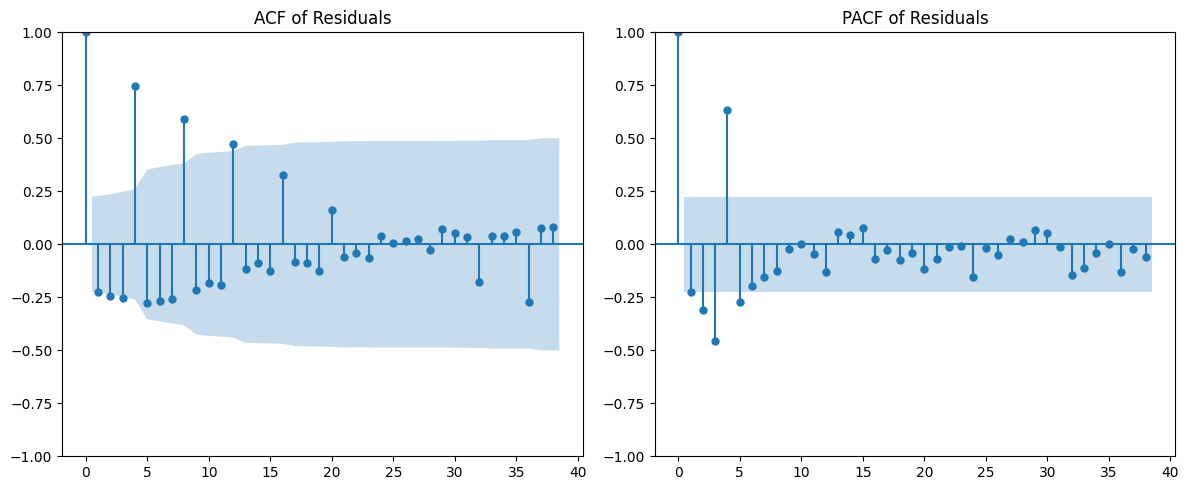

In [20]:
# ---  ACF and PACF Plots of Residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=38, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=38, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()

In [21]:
# --- Perform Ljung-Box Test ---
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")

Ljung-Box p-value: 0.0000


Try and predict the last 16 quarters (4 years) of the time series. Create the plot of the prediction, using the last 8 years of data (32 quarters).

C:\Users\SLO\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\SLO\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


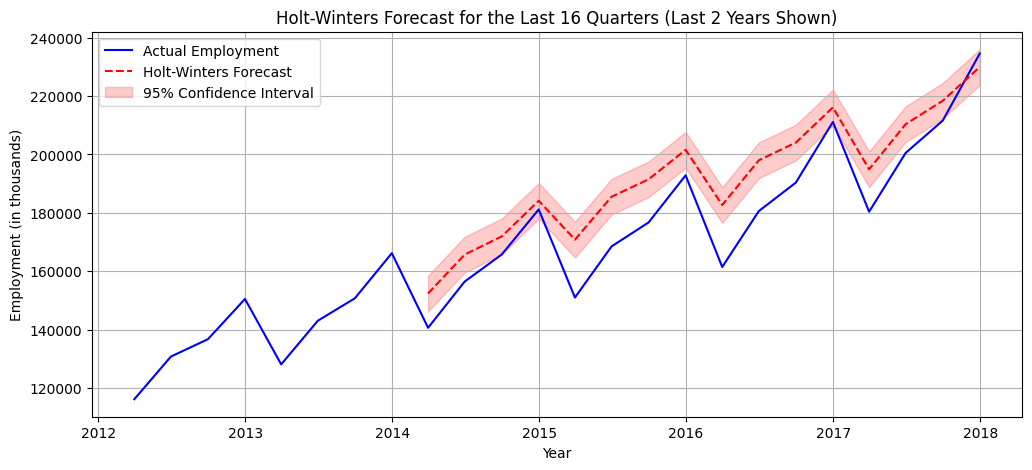

In [25]:
# TRY ADAPTING THE CODE TO FORECAST THE LAST 16 QUARTERS (FOUR YEARS) OF THE CHINESE GDP
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split the dataset: exclude the last 12 months for training
train_data = gdpchina.iloc[:-16]  # Use all but the last 12 months for training
test_data = gdpchina.iloc[-16:]   # Last 12 months for testing

# Fit Holt-Winters Exponential Smoothing model (seasonal period = 12 for monthly data)
hw_model = ExponentialSmoothing(
    train_data["GDP"],
    trend="add",
    seasonal="add",
    seasonal_periods=16
).fit()

# Forecast the next 12 months all at once without refitting
forecast_values = hw_model.forecast(steps=16)

# Estimate confidence intervals using residual standard deviation
residuals = train_data["GDP"] - hw_model.fittedvalues
std_dev = np.std(residuals)
confidence_interval = 1.96 * std_dev  # 95% Confidence Interval

# Convert forecasted values to a Pandas Series with the correct index
forecast_series = pd.Series(forecast_values.values, index=test_data.index)

# Select the last two years of actual data for plotting
df_last2years = gdpchina.iloc[-24:]  # Show the last 24 months of data

# Plot actual vs forecasted values (only last two years)
plt.figure(figsize=(12, 5))
plt.plot(df_last2years.index, df_last2years["GDP"], color="blue", label="Actual Employment")
plt.plot(forecast_series.index, forecast_series, color="red", linestyle="dashed", label="Holt-Winters Forecast")

# Plot confidence intervals
plt.fill_between(
    forecast_series.index,
    forecast_series - confidence_interval,
    forecast_series + confidence_interval,
    color="red", alpha=0.2, label="95% Confidence Interval"
)

plt.title("Holt-Winters Forecast for the Last 16 Quarters (Last 2 Years Shown)")
plt.xlabel("Year")
plt.ylabel("Employment (in thousands)")
plt.legend()
plt.grid()
plt.show()